# Code-along 2025-01-15 Build an AI Movie Night Recommendation Tool


In this code-along, we will be building an AI Movie Night Recommendation Tool! 

To do this, we will be using two data sets: 
- Movies metadata: A data set containing metadata of about 9000 movies (title, description, etc.)
- User ratings: A data set containing ratings of how much someone liked a movie. 

We will be building towards our end goal by covering the following tasks: 
- Understanding the data set by doing some basic exploratory analysis 
- Building a first recommender based on movie popularity or movie ratings 
- Personalising recommendations by exploiting user ratings 
- Leveraging LLMs to calculate similarity between movies 
- Generating a recommendation by writing what kind of movies you'd like to see 
- Putting it all together into one single recommendation tool

This code-along is aimed at anyone just starting to code by showing how you can build something useful by simply writing prompts to analyse data sets. The code generated is sufficiently challenging, however, for the more seasoned data person to play around with.

### A note on using the solution 

This solution notebook contains the code that we will work towards during the code-along. Given that we are coding using prompts and editing here and there, the solution code might not be exactly the same as the code during the code-along. 

This notebook is also heavily annotated with additional explanations and tidied up a bit to ensure each cell contains a concise piece of code. 

## Task 1: Import the ratings and movie metadata and explore it. 

The data is contained in two CSV files named `movies_metadata.csv` and `ratings.csv`

`movies_metadata` contains the following columns: 

- `movie_id`: Unique identifier of each movie. 
- `title`: Title of the movie. 
- `overview`: Short description of the movie. 
- `vote_average`: Average score the movie got.
- `vote_count`: Total number of votes the movie got. 

`ratings` contains the following columns: 

- `user_id`: Unique identifier of the person who rated the movie. 
- `movie_id`: Unique identifier of the movie. 
- `rating`: Value between 0 and 10 indicating how much the person liked the movie. 

### Prompt 
Read the movies_metadata file and count how many unique movies there are, visualise the vote_average column and visualise the vote_count column. Next read the ratings file, and count how many unique users have rated how many unique movies. Visualise the distribution of the rating column.

The above prompt generates approximately 50 lines of code in one cell, that are broken down in separate cells below. 

First, we start with importing the neccesary libraries to be able to run the code. `pandas` is used for manipulating data, whereas `matplotlib` and `seaborn` are data visualisation libraries. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Next, we read the data that is stored as a CSV file alongside this notebook. We read both the metadata and ratings data in one go. 

In [2]:
# Read the movies_metadata file
movies_metadata = pd.read_csv('movies_metadata.csv')

# Read the ratings file
ratings = pd.read_csv('ratings.csv')

In a first step, we want to know how many unique movies we have in our data set, and how many users have rated how many movies. 
We can see that the number of movies in both data sets are the same, and we have data from 671 users. 

In [4]:
# Count how many unique movies there are
unique_movies = movies_metadata['movie_id'].nunique()
print(f"Number of unique movies: {unique_movies}")

# Count how many unique users have rated how many unique movies
unique_users = ratings['user_id'].nunique()
unique_rated_movies = ratings['movie_id'].nunique()
print(f"Number of unique users: {unique_users}")
print(f"Number of unique rated movies: {unique_rated_movies}")

Number of unique movies: 9010
Number of unique users: 671
Number of unique rated movies: 9010


In the metadata data set, there are two fields indicating how many ratings a movie has received as well as what the average rating is. 
The code below shows the distribution of both fields. We can see that vote averages are centered around 7 with slightly more movies lower than 7 compared to higher than 7. 
In the vote count distribution, we can see that many movies don't receive many ratings, and a few movies receive *a lot of ratings*. 

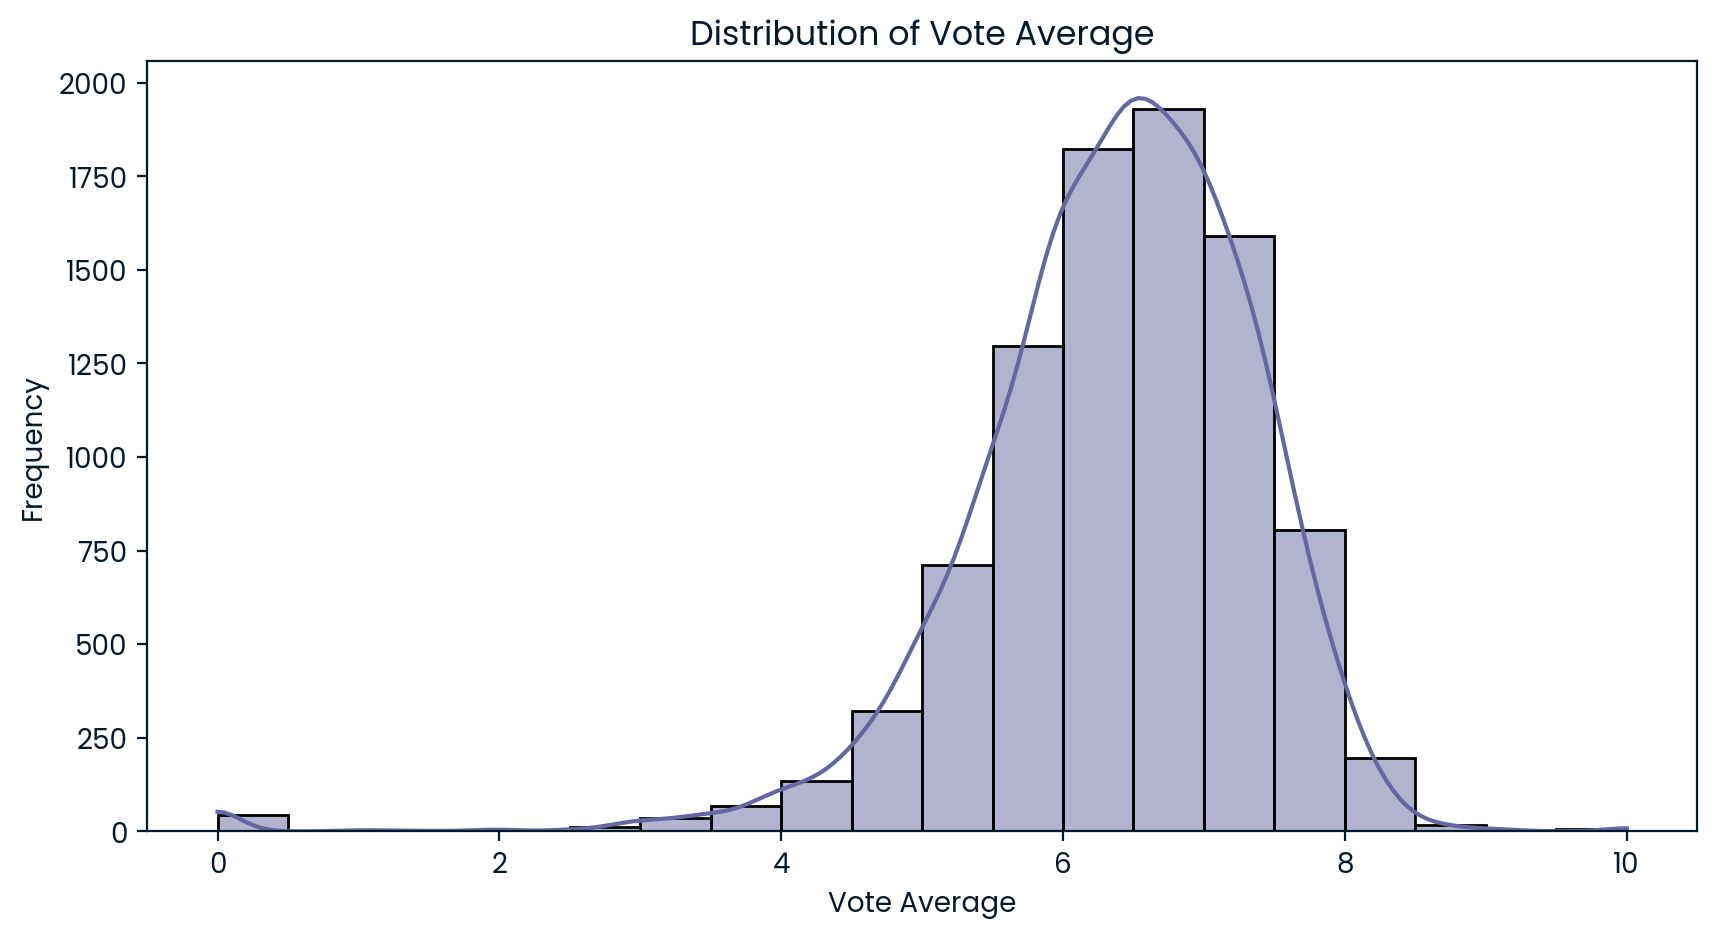

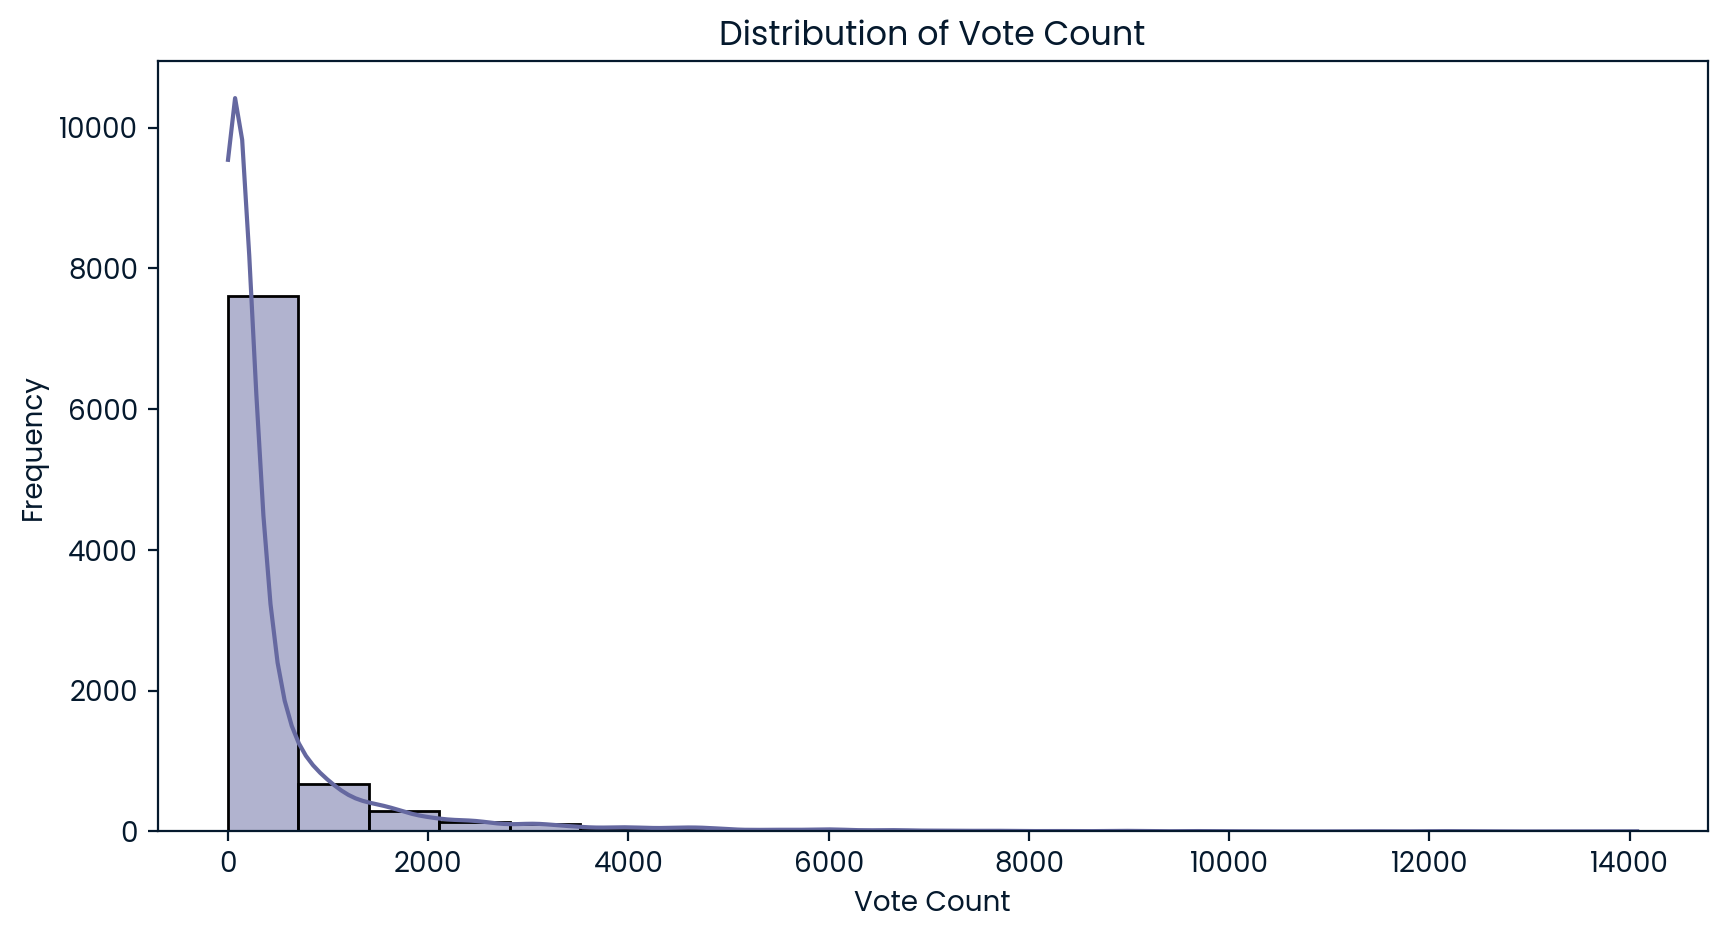

In [5]:
# Visualise the vote_average column
plt.figure(figsize=(10, 5))
sns.histplot(movies_metadata['vote_average'], bins=20, kde=True)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()

# Visualise the vote_count column
plt.figure(figsize=(10, 5))
sns.histplot(movies_metadata['vote_count'], bins=20, kde=True)
plt.title('Distribution of Vote Count')
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.show()

Zooming in on the user ratings, we can see a peculiar pattern where some ratings are much more frequently given compared to others. 
It turns out that this data doesn't have ratings between 1 and 10 but between 0.5 and 5, and it is clear people are biased towards giving "full" scores rather than including half points. 

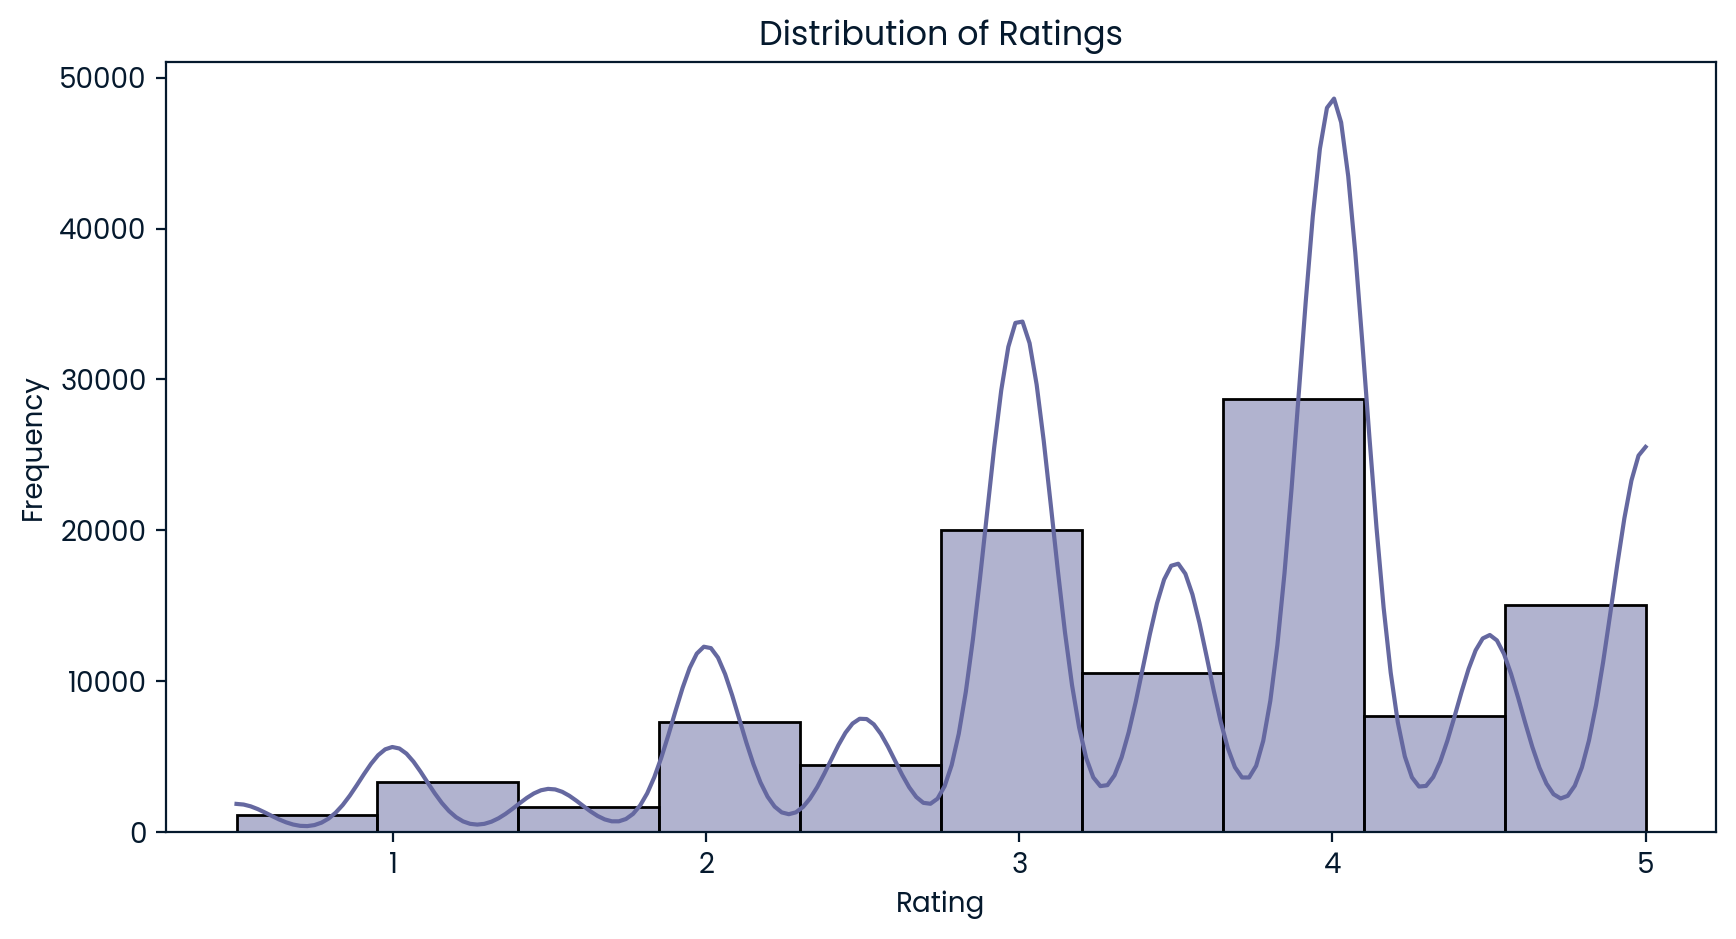

In [11]:
# Visualise the distribution of the rating column
plt.figure(figsize=(10, 5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

If you want to play around with the solution of Task 1, you can try the following: 
- Remove the density line overlaying the bars, as it is not always informative
- Adjust the number of bins shown, this can show different patterns depending on the granularity of the data
- The titles of the graphs are automatically generated, so you can try and adjust these to be more informative. 

If you want to take the code a step further: 
- The vote count distribution is not clear, try to log transform the count variable and see what happens! 
- heatmap of user by movie rating on a subset of the data 

## Task 2: Simple recommender based on popularity or highest rating

In short, a recommender is any system that generates suggestions for an end user. We will start with creating the simplest recommender, one that ranks all movies according to the highest average score, or the highest number of votes. 

This kind of recommender generates the same output for anyone using it. 

### Prompt 

Based on movies_metadata, generate a simple recommender that generates recommended movies by either the vote_average or the vote_count. The recommender should be configurable in how many movies it recommends and based on which criterion. 

The output of this prompt is a *function* called `simple_recommender`. If you are not familiar with functions, you can think about them like putting together a fixed series of steps that can be applied to any input. In this case, the input is a data set (`movies_metadata`) and a *criterion* (`vote_average`) together with an argument called `top_n`, which allows you to configure how many movies you want to see recommended. 

The steps the function goes through are the following: 
1. check the `criterion` argument, as it can only be two values. If that is not the case, raise an error. 
2. sort the movies by the criterion.
3. take the number of recommended movies as specificed by top_n.
4. return those top_n recommended movies. 

In [3]:
def simple_recommender(movies_metadata, criterion='vote_average', top_n=10):
    """
    Generate a simple recommender based on the specified criterion.
    
    Parameters:
    - movies_metadata (DataFrame): DataFrame containing movie metadata.
    - criterion (str): Criterion to base recommendations on ('vote_average' or 'vote_count').
    - top_n (int): Number of top movies to recommend.
    
    Returns:
    - DataFrame: Top recommended movies based on the specified criterion.
    """
    if criterion not in ['vote_average', 'vote_count']:
        raise ValueError("Criterion must be either 'vote_average' or 'vote_count'")
    
    # Sort movies by the specified criterion in descending order
    recommended_movies = movies_metadata.sort_values(by=criterion, ascending=False)
    
    # Select the top N movies
    top_recommended_movies = recommended_movies.head(top_n)
    
    return top_recommended_movies[['movie_id', 'title', 'overview', criterion]]

,movie_id,title,overview,vote_count
67,1375666.0,Inception,"Cobb, a skilled thief who commits corporate es...",14075.0
5577,468569.0,The Dark Knight,Batman raises the stakes in his war on crime. ...,12269.0
5761,499549.0,Avatar,"In the 22nd century, a paraplegic Marine is di...",12114.0
8033,848228.0,The Avengers,When an unexpected enemy emerges and threatens...,12000.0
6935,1431045.0,Deadpool,Deadpool tells the origin story of former Spec...,11444.0
278,816692.0,Interstellar,Interstellar chronicles the adventures of a gr...,11187.0
6711,1853728.0,Django Unchained,"With the help of a German bounty hunter, a fre...",10297.0
1360,2015381.0,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",10014.0
7828,137523.0,Fight Club,A ticking-time-bomb insomniac and a slippery s...,9678.0
4484,1392170.0,The Hunger Games,Every year in the ruins of what was once North...,9634.0


The code below then shows how you can use and re-use this functions to get different output. 

In [ ]:
# Example usage:
top_movies_by_average = simple_recommender(movies_metadata, criterion='vote_average', top_n=10)
top_movies_by_count = simple_recommender(movies_metadata, criterion='vote_count', top_n=10)

# Display the top recommended movies
top_movies_by_average
top_movies_by_count

To simplify things a bit, we can take out the most critical line and just create the recommender as one line of code. To do so, we *chain* together different manipulations to the data (sorting, and then selecting the first X rows).

In [12]:
movies_metadata.sort_values(by='vote_count', ascending=False).head(10)

,movie_id,title,overview,vote_average,vote_count
67,1375666.0,Inception,"Cobb, a skilled thief who commits corporate es...",8.1,14075.0
5577,468569.0,The Dark Knight,Batman raises the stakes in his war on crime. ...,8.3,12269.0
5761,499549.0,Avatar,"In the 22nd century, a paraplegic Marine is di...",7.2,12114.0
8033,848228.0,The Avengers,When an unexpected enemy emerges and threatens...,7.4,12000.0
6935,1431045.0,Deadpool,Deadpool tells the origin story of former Spec...,7.4,11444.0
278,816692.0,Interstellar,Interstellar chronicles the adventures of a gr...,8.1,11187.0
6711,1853728.0,Django Unchained,"With the help of a German bounty hunter, a fre...",7.8,10297.0
1360,2015381.0,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",7.9,10014.0
7828,137523.0,Fight Club,A ticking-time-bomb insomniac and a slippery s...,8.3,9678.0
4484,1392170.0,The Hunger Games,Every year in the ruins of what was once North...,6.9,9634.0


If you want to play around with the solution of Task 2, you can try the following: 
- Currently, the function returns the whole data frame, but you might consider returning only one or two columns, or formatting the output totally differently. 
- The function validates whether the right columns are selected for sorting on, try out what happens when you give the wrong input to the `criterion` argument. 

## Task 3: Generate recommendations based on user ratings

We already created a very simple first recommender, but we haven't touched our user data yet! How can this help us? When you watched a movie you liked, you might want to learn which other movies other users liked that also watched that movie. This is where the user data comes in. We can use the ratings to infer which movies are similar to a movie you have already watched! 

### Prompt
Create a recommender that uses the ratings data and generates movie recommendations when you put in a specific movie title.

The output of the prompt is about 35 lines of code that ends with spitting out a list of movies similar to a movie you put in. 
Below, we broke everything down to explain it in detail. 

We start again with importing relevant libraries. The `pandas` import is redundant given that we already did it earlier. The second import is worth calling out however. The `sklearn` library is one of the most well-known libraries for doing all things machine learning in Python. From this library, we import the `cosine_similarity` function, which we'll explain later. The third import seems a bit odd, as we don't use the function anywere in the solution code. A bit of AI Hallunication?? 

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

Next, we create a single big data set by joining the ratings to to the metadata. This will be useful for getting the movie titles of the movies we are recommending. 

In [ ]:
# Merge movies metadata with ratings
movies_ratings = pd.merge(ratings, movies_metadata, on='movie_id')

We currently have a very long data set, where each row is a combination of user, movie, and a rating. The recommendation we will be creating however, is a similarity of ratings between movies, so we need a data representation where each movie is its own column, and each user is its own row. This is achieved by pivoting the table to a user x movie representation. 

In [ ]:
# Create a pivot table with users as rows and movies as columns
user_movie_ratings = movies_ratings.pivot_table(index='user_id', columns='title', values='rating')

Now that we have this table, a lot of empty cells have been generated. Indeed, not everyone rated all movies. In order for our calculations to work, we need to come up with a value to replace those missing values with (this is also called missing value imputation). For now, we simply replace all empty cells with a value of 0. 

In [ ]:
# Fill NaN values with 0 (assuming unrated movies have a rating of 0)
user_movie_ratings = user_movie_ratings.fillna(0)

With all missing values gone, we can now turn to the computation that is at the core of our recommendations. We apply the `cosine_similarity` function to our data set. What this boils down to is that for each pair of columns (movies) we will compute how similar the ratings are. If all ratings are the same between two movies, they are highly similar (if not the same) and if you would ask for a recommendation based on one of these two movies we would definitely recommend the other. Vice versa, if all ratings were opposite between two movies, we would almost never recommend one based on the other. 

In [ ]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(user_movie_ratings.T)

# Create a DataFrame for the cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=user_movie_ratings.columns, columns=user_movie_ratings.columns)

As a final step, we can again wrap this in a function that takes a movie title as input, together with the movie similarity data set and the number of recommendations you want. 
What happens in this function is that the column is taken that is equal to the movie title. Next, the values are sorted according to their similarity score. Finally we take the top_n movies in the list. 
Interestingly, we index from 1:num_recommendations+1 - why? The movie that is most similar in terms of ratings is the movie itself! So we discard that by not taking the movie with index 0. 

In [ ]:
def get_recommendations(movie_title, cosine_sim_df, num_recommendations=10):
    # Get the similarity scores for the given movie
    sim_scores = cosine_sim_df[movie_title]
    
    # Sort the movies based on the similarity scores
    sim_scores = sim_scores.sort_values(ascending=False)
    
    # Get the top N recommendations (excluding the input movie itself)
    top_recommendations = sim_scores.iloc[1:num_recommendations+1]
    
    return top_recommendations

In [4]:
# Example usage
movie_title = "The Godfather"  # Replace with the movie title you want recommendations for
recommendations = get_recommendations(movie_title, cosine_sim_df)
recommendations

title
The Godfather: Part II             0.773685
GoodFellas                         0.620349
One Flew Over the Cuckoo's Nest    0.568244
American Beauty                    0.557997
Star Wars                          0.546750
Raiders of the Lost Ark            0.538185
Saving Private Ryan                0.534684
Apocalypse Now                     0.534347
Reservoir Dogs                     0.531713
The Usual Suspects                 0.530727
Name: The Godfather, dtype: float64

If you want to play around with the solution of Task 3, you can try the following: 
- You can remove the redundant import of the TfidfVectorizer and see whether the code still works. 
- Missing data imputation can be very simple to very complex. Try to come up with other methods of imputing missing data, like taking a user's average score, or the movies' average score etc. 

If you want to take the code a step further: 
- You might have seen movies that are recommended already, try and tweak the function such that it allows excluding movies that you have already seen.

## Task 4: Generate embeddings based on the movie descriptions

So far, we already created two recommenders! One that didn't take into account your preferences, and one that suggested movies based on similarity to a movie you already saw. Now, we will get creative and let you write a summary of the kind of move you'd like to watch to get recommendations back! 

In order to do this, we will rely on a concept called *embeddings*. In a nutshell, embeddings are numerical representations of a piece of text and they are critical to the success of the most recent generation of AI models, like ChatGPT. We will take the description of our movies and convert these to their embedded form. 

### Prompt  
Take the overview field from movies_metadata. These are short descriptions from movies. Use a simple local llm model to generate embeddings for each movie 

The prompt generates only a few lines of code, but there is a lot going on here. Let's to through it chunk by chunk. 

The most important library we are using in this task is called `sentence_transformers`. Very shortly put, a sentence transformer is a type of LLM that allows us to transform a sentence into a numerical representation. For example, the sentence "I have a dog." can be transformed into a representation of numbers and these numbers have an interesting property. The closer they are together, the more semantically similar they are. These numbers are called sentence embeddings, and we can use them to quantify how similar each movie description is to all other movie descriptions. More interestingly however, we can then compare arbitrary sentences with each movie and compute how similar that one sentence is tot each movie (but that's for the next task!).  

In [8]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm

This line simply loads a transformer model, of which there consist many. This one is relatively small which means you don't need a sophisticated machine to run it on. The downside is that the result won't be as impressive as with LLMs like ChatGPT. 

In [9]:
# Load a pre-trained model from Sentence Transformers
model = SentenceTransformer('all-MiniLM-L6-v2')

After ensuring all movie descriptions have no missing values, we `apply` `model.encode()` to each row of the data frame. This will generate an embedding of each description. You can verify this for yourself by taking a single row of the `embedding` column of the data frame after the cell has finished running, which can take approximately 3 to 5 minutes. 

In [10]:
# Ensure the 'overview' column is filled with strings
movies_metadata['overview'] = movies_metadata['overview'].fillna('').astype(str)

# Generate embeddings for each movie overview
tqdm.pandas(desc="Generating embeddings")
movies_metadata['embedding'] = movies_metadata['overview'].progress_apply(lambda x: model.encode(x).tolist())

Generating embeddings: 100%|██████████| 9010/9010 [03:06<00:00, 48.36it/s]


## Task 5: Use embedding simillarity to generate recommendations

Now we are ready to create a new recommender function where we submit a description of a movie we want to watch and get recommendations back. 

### Prompt 
Create a recommender that takes the embeddings in movies_metadata and a user-generated input that describes a movie they'd like to watch. Calculate the similarity between the embedding of that description with all movie embeddings and return the top n most similar movies.

The output of the prompt reuses what we created in the previous task, and wraps it into a function. Let's have a look at what's happening. 

The `recommend_movies` function takes a particular `user_input`, the metadata data set, a model, and a `top_n` argument. The user input can be anything, but preferably a short sentence describing what kind of movie you'd like to see. The metadata is being used to retrieve the embeddings we generated, and the model will be used to generate the embedding of the input text. 

The function goes through the following steps: 
- Create an embedding of the input text. 
- Calculate the similarity between the input text embedding and the embedding of all movies. 
- Sort based on those similarity values and select top_n. 
- Return a subset of the data set with the movie title and description. 

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(user_input, movies_metadata, model, top_n=5):
    # Generate embedding for the user input
    user_embedding = model.encode(user_input).tolist()
    
    # Calculate cosine similarity between user input embedding and all movie embeddings
    movies_metadata['similarity'] = movies_metadata['embedding'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0])
    
    # Sort movies by similarity in descending order and get the top n movies
    top_movies = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
    
    return top_movies[['title', 'overview', 'similarity']]

,title,overview,similarity
5579,The Wizard of Oz,Young Dorothy finds herself in a magical world...,0.516829
2556,Stardust,In a countryside town bordering on a magical l...,0.458553
7106,The Illusionist,"Scotland, late 1950s. A struggling illusionist...",0.455771
6378,The Raven,A magician who has been turned into a raven tu...,0.453578
5075,August Rush,"A drama with fairy tale elements, where an orp...",0.443685


Below you can see how we would use the function to generate a few suggested movies. 

In [ ]:
# Example usage
user_input = "A story about a young wizard who discovers his magical heritage."
top_n = 5
recommended_movies = recommend_movies(user_input, movies_metadata, model, top_n)
recommended_movies

If you want to play around with the solution of Task 5, you can try the following: 
- Change the input text to anything you'd like to see, and see if the output makes sense.  

## Task 6: Put it all together into a single function

In this final task, we will be putting all previous recommenders together into one single function that will allow you to generate an awesome movie night! 

### Prompt
Combine the three different recommenders we used before, the first one being a recommender based on vote_average or vote_count, the second one based on the ratings data where the most similar movies would be returned for a given movie title, and the third one being a recommender based on the movie embeddings that are most similar to a user-generated prompt. One of the three options should be returned.

This prompt generates quite the function that doesn't seem to incorporate the previous functions we have created. Instead, it tries to recreate what we already did previously. 

Try to inspect for yourself what is happening here, and in the code cell below we will try to come up with a different function that actually reuses our code. 

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies(method='vote_average', movie_title=None, user_prompt=None, top_n=10):
    if method == 'vote_average':
        # Recommender based on vote_average or vote_count
        recommended = movies_metadata.sort_values(by=['vote_average', 'vote_count'], ascending=False).head(top_n)
        return recommended[['title', 'overview', 'vote_average', 'vote_count']]
    
    elif method == 'similar_movies' and movie_title:
        # Recommender based on the ratings data where the most similar movies would be returned for a given movie title
        movie_id = movies_metadata[movies_metadata['title'] == movie_title]['movie_id'].values[0]
        user_ratings = ratings[ratings['movie_id'] == movie_id]
        similar_users = ratings[ratings['user_id'].isin(user_ratings['user_id'])]
        similar_movies = similar_users.groupby('movie_id').agg({'rating': 'mean'}).reset_index()
        similar_movies = similar_movies.merge(movies_metadata, on='movie_id')
        similar_movies = similar_movies.sort_values(by='rating', ascending=False).head(top_n)
        return similar_movies[['title', 'overview', 'rating']]
    
    elif method == 'embedding' and user_prompt:
        # Recommender based on the movie embeddings that are most similar to a user-generated prompt
        user_embedding = np.mean([movies_metadata[movies_metadata['title'] == title]['embedding'].values[0] for title in user_prompt], axis=0)
        movies_metadata['similarity'] = movies_metadata['embedding'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0])
        recommended = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
        return recommended[['title', 'overview', 'similarity']]
    
    else:
        raise ValueError("Invalid method or missing parameters")

# Example usage:
recommend_movies(method='vote_average', top_n=5)
# recommend_movies(method='similar_movies', movie_title='The Matrix', top_n=5)
# recommend_movies(method='embedding', user_prompt=['The Matrix', 'Inception'], top_n=5)

,title,overview,vote_average,vote_count
430,Survive and Advance,"In 1983, the NC State Wolfpack, coached by Jim...",10.0,2.0
7463,Common Threads: Stories from the Quilt,"In the late 1970s, a mysterious new disease be...",10.0,2.0
873,"Dancer, Texas Pop. 81","Four guys, best friends, have grown up togethe...",10.0,1.0
2882,"The Haunted World of Edward D. Wood, Jr.",The strange life and the wonderfully awful fil...,10.0,1.0
6603,Chilly Scenes of Winter,A man falls for a separated woman but can't co...,10.0,1.0


First, let's copy over the previous functions we generated so that we remember what input they needed. 

To define a more generic function, we need to see what's common, and what's different between the different recommenders: 
- All three need a data set to draw from 
- All three need some additional input, be it a variable to sort on, a movie to compute similarity against, or a description of movies you want to watch. 

In [ ]:
# popularity-based recommender 
def popularity_recommender(movies_metadata, criterion='vote_average', top_n=10):
    if criterion not in ['vote_average', 'vote_count']:
        raise ValueError("Criterion must be either 'vote_average' or 'vote_count'")
    
    # Sort movies by the specified criterion in descending order
    recommended_movies = movies_metadata.sort_values(by=criterion, ascending=False)
    
    # Select the top N movies
    top_recommended_movies = recommended_movies.head(top_n)
    
    return top_recommended_movies[['movie_id', 'title', 'overview', criterion]]

# user rating based recommender 
def rating_recommender(movie_title, cosine_sim_df, num_recommendations=10):
    # Get the similarity scores for the given movie
    sim_scores = cosine_sim_df[movie_title]
    
    # Sort the movies based on the similarity scores
    sim_scores = sim_scores.sort_values(ascending=False)
    
    # Get the top N recommendations (excluding the input movie itself)
    top_recommendations = sim_scores.iloc[1:num_recommendations+1]
    
    return top_recommendations

# movie description based recommender  
def movie_description_recommender(user_input, movies_metadata, model, top_n=5):
    # Generate embedding for the user input
    user_embedding = model.encode(user_input).tolist()
    
    # Calculate cosine similarity between user input embedding and all movie embeddings
    movies_metadata['similarity'] = movies_metadata['embedding'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0])
    
    # Sort movies by similarity in descending order and get the top n movies
    top_movies = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
    
    return top_movies[['title', 'overview', 'similarity']]

In [2]:
def movie_night_recommender(df, method = 'popularity', criterion = None, user_input = None, model = None, top_n = 5): 
    if method == 'popularity': 
        return simple_recommender(df, criterion=criterion, top_n=top_n)
    elif method == 'rating_similarity': 
        return rating_recommender(movie_title = user_inpt, cosine_sim_df = df, num_recommendations = top_n) 
    elif method == 'movie_description': 
        return movie_description_recommender(user_input = user_input, movies_metadata = df, model = model, top_n=top_n) 
    else: 
        raise ValueError("Method must be one of: popularity, rating_similarity, or movie_description")

If you want to take the code a step further: 
- Try to combine the different recommender functions by making them dependent on each other and generate more clever output. Think about mixing recommendations, taking only the most popular ones and calculating similarity against those etc. 